In [86]:
import xarray as xr
import numpy as np
import pandas as pd 
from scipy import stats as st
import geopandas as gpd
from glob import glob
from shapely.geometry import mapping
import spei
from climate_indices import compute, indices, utils
import warnings

warnings.filterwarnings("ignore")

In [4]:
TP_shp = gpd.read_file('/Users/zeqinhuang/Documents/dataset/Maps/Tibetan_Plateau/Tibetan_Plateau2.shp')

In [5]:
_FITTED_INDEX_VALID_MIN = -3.09
_FITTED_INDEX_VALID_MAX = 3.09

# modified from climate_indices.indices.spi
# we thank the original author for the code https://github.com/monocongo/climate_indices/tree/master

def si(
    values: np.ndarray,
    scale: int,
    distribution: indices.Distribution,
    data_start_year: int,
    calibration_year_initial: int,
    calibration_year_final: int,
    periodicity: compute.Periodicity,
) -> np.ndarray:
    """
    Computes SI (Standardized Index).

    :param values: 1-D numpy array of precipitation values, in any units,
        first value assumed to correspond to January of the initial year if
        the periodicity is monthly, or January 1st of the initial year if daily
    :param scale: number of time steps over which the values should be scaled
        before the index is computed
    :param distribution: distribution type to be used for the internal
        fitting/transform computation
    :param data_start_year: the initial year of the input precipitation dataset
    :param calibration_year_initial: initial year of the calibration period
    :param calibration_year_final: final year of the calibration period
    :param periodicity: the periodicity of the time series represented by the
        input data, valid/supported values are 'monthly' and 'daily'
        'monthly' indicates an array of monthly values, assumed to span full
         years, i.e. the first value corresponds to January of the initial year
         and any missing final months of the final year filled with NaN values,
         with size == # of years * 12
         'daily' indicates an array of full years of daily values with 366 days
         per year, as if each year were a leap year and any missing final months
         of the final year filled with NaN values, with array size == (# years * 366)
    :param fitting_params: optional dictionary of pre-computed distribution
        fitting parameters, if the distribution is gamma then this dict should
        contain two arrays, keyed as "alphas" and "betas", and if the
        distribution is Pearson then this dict should contain four arrays keyed
        as "probabilities_of_zero", "locs", "scales", and "skews"
    :return SPI values fitted to the gamma distribution at the specified time
        step scale, unitless
    :rtype: 1-D numpy.ndarray of floats of the same length as the input array
        of precipitation values
    """

    # we expect to operate upon a 1-D array, so if we've been passed a 2-D array
    # then we flatten it, otherwise raise an error
    shape = values.shape
    if len(shape) == 2:
        values = values.flatten()
    elif len(shape) != 1:
        message = (
            "Invalid shape of input array: {shape}".format(shape=shape)
            + " -- only 1-D and 2-D arrays are supported"
        )
        raise ValueError(message)

    # if we're passed all missing values then we can't compute
    # anything, so we return the same array of missing values
    if (np.ma.is_masked(values) and values.mask.all()) or np.all(np.isnan(values)):
        return values

    # clip any negative values to zero
    if np.amin(values) < 0.0:
        # print("Input contains negative values -- all negatives clipped to zero")
        values = np.clip(values, a_min=0.0, a_max=None)

    # remember the original length of the array, in order to facilitate
    # returning an array of the same size
    original_length = values.size

    # get a sliding sums array, with each time step's value scaled
    # by the specified number of time steps
    values = compute.sum_to_scale(values, scale)

    # reshape precipitation values to (years, 12) for monthly,
    # or to (years, 366) for daily
    if periodicity is compute.Periodicity.monthly:
        values = utils.reshape_to_2d(values, 12)

    elif periodicity is compute.Periodicity.daily:
        values = utils.reshape_to_2d(values, 366)

    else:
        raise ValueError("Invalid periodicity argument: %s" % periodicity)

    if distribution is indices.Distribution.gamma:
        # fit the scaled values to a gamma distribution
        # and transform to corresponding normalized sigmas
        values = compute.transform_fitted_gamma(
            values,
            data_start_year,
            calibration_year_initial,
            calibration_year_final,
            periodicity,
        )
    elif distribution is indices.Distribution.pearson:
        # fit the scaled values to a Pearson Type III distribution
        # and transform to corresponding normalized sigmas
        values = compute.transform_fitted_pearson(
            values,
            data_start_year,
            calibration_year_initial,
            calibration_year_final,
            periodicity,
        )

    else:
        message = "Unsupported distribution argument: " + "{dist}".format(
            dist=distribution
        )
        raise ValueError(message)

    # clip values to within the valid range, reshape the array back to 1-D
    values = np.clip(values, _FITTED_INDEX_VALID_MIN, _FITTED_INDEX_VALID_MAX).flatten()

    # return the original size array
    return values[0:original_length]

In [6]:
def apply_si_gamma_monthly(
    data_array: xr.DataArray,
    months: int,
    data_start_year: int = 1979,
    calibration_year_initial: int = 1979,
    calibration_year_final: int = 2022,
) -> xr.DataArray:
    # stack the lat and lon dimensions into a new dimension named point, so at each lat/lon
    # we'll have a time series for the geospatial point, and group by these points
    da_precip_groupby = data_array.stack(point=("lat", "lon"))#.groupby("point")

    spi_args = {
        "scale": months,
        "distribution": indices.Distribution.gamma,
        "data_start_year": data_start_year,
        "calibration_year_initial": calibration_year_initial,
        "calibration_year_final": calibration_year_final,
        "periodicity": compute.Periodicity.monthly,
    }

    # apply the SPI function to the data array
    da_spi = xr.apply_ufunc(
        si,
        da_precip_groupby,
        kwargs=spi_args,
        dask="parallelized",
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
    )

    # unstack the array back into original dimensions
    da_spi = da_spi.unstack("point")

    return da_spi

# Calculate SPI3 and STI3 based on ERA5 data

In [5]:
# calculate SPI3
ERA5_tp_monthly = xr.open_dataset('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/ERA5/ERA5_TP_tp_monthly_1979_2023.nc')
ERA5_tp_monthly = ERA5_tp_monthly.tp
ERA5_tp_monthly = ERA5_tp_monthly.sel(time=slice('1979-01-01', '2023-12-01'))
ERA5_tp_monthly = ERA5_tp_monthly*86400

ds_spi = apply_si_gamma_monthly(ERA5_tp_monthly, 3)

# clip ds_spi with TP shapefile
ds_spi.rio.set_crs("epsg:4326")
ds_spi.rio.set_spatial_dims("lon", "lat", inplace=True)
ds_spi = ds_spi.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)

# save to netcdf
ds_spi.name = 'SPI3'
ds_spi.attrs['units'] = 'unitless'
ds_spi.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_spi3_monthly_1979_2023.nc')

# select month=3 and save to netcdf
# note that the year here is not water year, but calendar year
ds_spi_yearly = ds_spi.sel(time=ds_spi['time.month']==3)
ds_spi_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_spi3_yearly_1979_2023.nc')


In [7]:
# calculate STI3 using the same function
ERA5_t2m_monthly = xr.open_dataset('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/ERA5/ERA5_TP_t2m_monthly_1979_2023.nc')
ERA5_t2m_monthly = ERA5_t2m_monthly.t2m
ERA5_t2m_monthly = ERA5_t2m_monthly.sel(time=slice('1979-01-01', '2023-12-01'))

ds_sti = apply_si_gamma_monthly(ERA5_t2m_monthly, 3)

# clip ds_sti with TP shapefile
ds_sti.rio.set_crs("epsg:4326")
ds_sti.rio.set_spatial_dims("lon", "lat", inplace=True)
ds_sti = ds_sti.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)

# save to netcdf
ds_sti.name = 'STI3'
ds_sti.attrs['units'] = 'unitless'
ds_sti.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_sti3_monthly_1979_2023.nc')

# select month=3 and save to netcdf
# note that the year here is not water year, but calendar year
ds_sti_yearly = ds_sti.sel(time=ds_sti['time.month']==3)
ds_sti_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_sti3_yearly_1979_2023.nc')

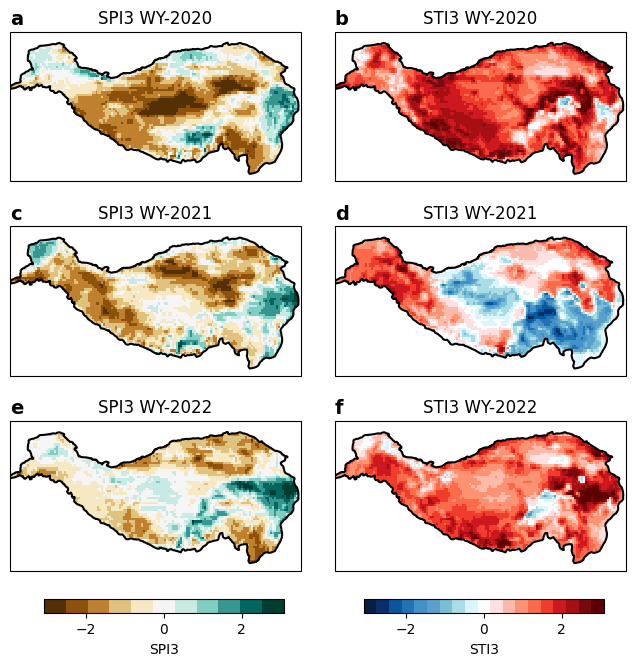

In [33]:
# plot a 3*2 figure to show the last three year March SPI3 and STI3
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.dates as mdates
import cmaps

def add_panel_label(ax, label, x = 0, y = 1.15):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(3, 2, figure=fig)
gs.update(wspace=0.1, hspace=0.3)
ax1 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax5 = fig.add_subplot(gs[2, 0], projection=ccrs.PlateCarree())
ax6 = fig.add_subplot(gs[2, 1], projection=ccrs.PlateCarree())

# SPI3
for i in range(3):
    p1 = ds_spi_yearly.sel(time=f'202{i+1}-03-01').plot(ax=fig.axes[i*2], transform=ccrs.PlateCarree(), cmap=cmaps.CBR_drywet, add_colorbar=False)
    fig.axes[i*2].coastlines()
    fig.axes[i*2].set_title(f'SPI3 WY-202{i}')

# STI3
for i in range(3):
    p2 = ds_sti_yearly.sel(time=f'202{i+1}-03-01').plot(ax=fig.axes[i*2+1], transform=ccrs.PlateCarree(), cmap=cmaps.temp_diff_18lev, add_colorbar=False)
    fig.axes[i*2+1].coastlines()
    fig.axes[i*2+1].set_title(f'STI3 WY-202{i}')

# add panel label
add_panel_label(ax1, 'a')
add_panel_label(ax2, 'b')
add_panel_label(ax3, 'c')
add_panel_label(ax4, 'd')
add_panel_label(ax5, 'e')
add_panel_label(ax6, 'f')

# set extent to [68, 105, 25, 41]
for ax in fig.axes:
    TP_shp.boundary.plot(ax=ax, color='black')
    ax.set_extent([68, 105, 25, 41], ccrs.PlateCarree())

# add colorbar
cbar_ax1 = fig.add_axes([0.17, 0.05, 0.3, 0.02])
cbar1 = plt.colorbar(p1, cax=cbar_ax1, orientation='horizontal')
cbar1.set_label('SPI3')
cbar_ax2 = fig.add_axes([0.57, 0.05, 0.3, 0.02])
cbar2 = plt.colorbar(p2, cax=cbar_ax2, orientation='horizontal')
cbar2.set_label('STI3')

fig.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/figures/SPI3_STI3_WY2020_2022.png', dpi=300, bbox_inches='tight')
fig.savefig('/Users/zeqinhuang/Documents/paper/TB_SWE/figures/SPI3_STI3_WY2020_2022.pdf', bbox_inches='tight')

In [40]:
# calculate area-weighted mean of SPI3 and STI3

weights = np.cos(np.deg2rad(ds_spi.lat))
weights.name = 'weights'
ds_spi_year_weighted = ds_spi_yearly.weighted(weights)
ds_spi_month_weighted = ds_spi.weighted(weights)
ds_spi_year_ts = ds_spi_year_weighted.mean(('lon','lat'))
ds_spi_month_ts = ds_spi_month_weighted.mean(('lon','lat'))

weights = np.cos(np.deg2rad(ds_sti.lat))
weights.name = 'weights'
ds_sti_year_weighted = ds_sti_yearly.weighted(weights)
ds_sti_month_weighted = ds_sti.weighted(weights)
ds_sti_year_ts = ds_sti_year_weighted.mean(('lon','lat'))
ds_sti_month_ts = ds_sti_month_weighted.mean(('lon','lat'))

# save to csv
ds_spi_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_spi3_yearly_1979_2023.csv')
ds_spi_month_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_spi3_monthly_1979_2023.csv')
ds_sti_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_sti3_yearly_1979_2023.csv')
ds_sti_month_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_sti3_monthly_1979_2023.csv')


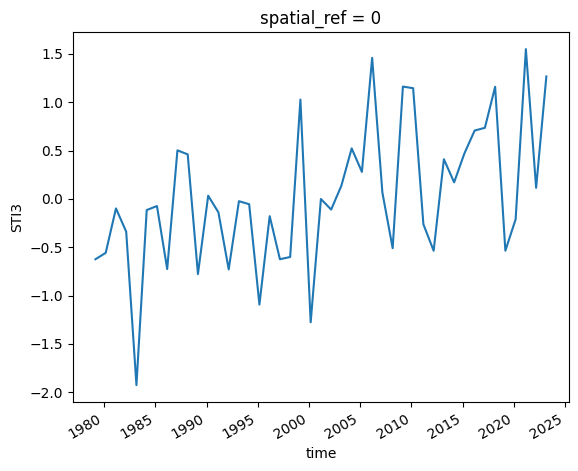

In [42]:
ds_sti_year_ts.plot()

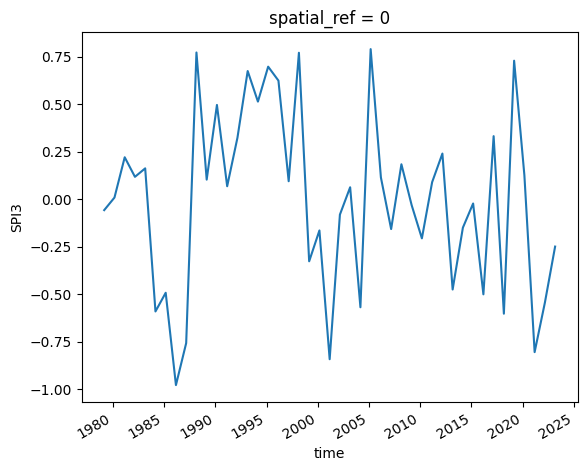

In [41]:
ds_spi_year_ts.plot()

# Calculate tcc, ssrd anomalies 

In [23]:
# group by DJFM and calculate the mean
def is_jfm(month):
    return (month >= 1) & (month <= 3)

In [26]:
ERA5_tcc = xr.open_dataarray('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/ERA5/ERA5_TP_tcc_monthly_1979_2023.nc')
ERA5_ssrd = xr.open_dataarray('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/ERA5/ERA5_TP_ssrd_monthly_1979_2023.nc')

ERA5_tcc.name  = 'tcc'
ERA5_ssrd.name = 'ssrd'

ERA5_tcc_JFM = ERA5_tcc.sel(time=is_jfm(ERA5_tcc['time.month']))
ERA5_ssrd_JFM = ERA5_ssrd.sel(time=is_jfm(ERA5_ssrd['time.month']))

ERA5_tcc_JFM_yearly = ERA5_tcc_JFM.groupby('time.year').mean('time')
ERA5_ssrd_JFM_yearly = ERA5_ssrd_JFM.groupby('time.year').mean('time')

ERA5_tcc_JFM_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_tcc_JFM_yearly_1979_2023.nc')
ERA5_ssrd_JFM_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/ERA5_TP_ssrd_JFM_yearly_1979_2023.nc')


# Calculate SPI3 and STI3 for CMIP6 data

In [7]:
hist_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CNRM-CM6-1', 'CanESM5', 'CanESM5-1', 'E3SM-1-0', 'E3SM-2-0',
'EC-Earth3','EC-Earth3-AerChem','EC-Earth3-CC','EC-Earth3-Veg','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','GISS-E2-1-H','GISS-E2-2-G','HadGEM3-GC31-LL','IPSL-CM5A2-INCA',
'IPSL-CM6A-LR','KIOST-ESM','MIROC6','MPI-ESM-1-2-HAM','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1']
SSP245_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'CIESM', 'CNRM-CM6-1', 'CanESM5', 'CanESM5-1',
'EC-Earth3','EC-Earth3-CC','EC-Earth3-Veg','GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','GISS-E2-1-H','GISS-E2-2-G','HadGEM3-GC31-LL',
'IPSL-CM6A-LR','KIOST-ESM','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorESM2-LM','NorESM2-MM','TaiESM1']
SSP370_source = ['E3SM-1-0', 'E3SM-2-0', 'EC-Earth3-AerChem','IPSL-CM5A2-INCA','MPI-ESM-1-2-HAM']
NAT_source = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'BCC-CSM2-MR', 'CESM2', 'CNRM-CM6-1', 'CanESM5', 'E3SM-2-0',
'GFDL-CM4','GFDL-ESM4','GISS-E2-1-G','HadGEM3-GC31-LL', 'IPSL-CM6A-LR','MIROC6', 'MRI-ESM2-0','NorESM2-LM']

hist_variant = {
    'ACCESS-CM2':'r1i1p1f1', 'ACCESS-ESM1-5':'r1i1p1f1', 'BCC-CSM2-MR':'r1i1p1f1', 'CESM2':'r10i1p1f1', 'CESM2-WACCM':'r1i1p1f1', 'CIESM':'r1i1p1f1', 
    'CNRM-CM6-1':'r1i1p1f2', 'CanESM5':'r1i1p1f1', 'CanESM5-1':'r1i1p1f1', 'E3SM-1-0':'r10i2p2f1', 'E3SM-2-0':'r1i1p1f1','EC-Earth3':'r1i1p1f1',
    'EC-Earth3-AerChem':'r1i1p1f1','EC-Earth3-CC':'r1i1p1f1','EC-Earth3-Veg':'r1i1p1f1','GFDL-CM4':'r1i1p1f1','GFDL-ESM4':'r1i1p1f1',
    'GISS-E2-1-G':'r101i1p1f1','GISS-E2-1-H':'r1i1p1f2','GISS-E2-2-G':'r1i1p3f1','HadGEM3-GC31-LL':'r1i1p1f3','IPSL-CM5A2-INCA':'r1i1p1f1',
    'IPSL-CM6A-LR':'r1i1p1f1','KIOST-ESM':'r1i1p1f1','MIROC6':'r1i1p1f1','MPI-ESM-1-2-HAM':'r1i1p1f1','MPI-ESM1-2-HR':'r1i1p1f1','MPI-ESM1-2-LR':'r1i1p1f1',
    'MRI-ESM2-0':'r1i1p1f1','NorESM2-LM':'r1i1p1f1','NorESM2-MM':'r1i1p1f1','TaiESM1':'r1i1p1f1'
}
SSP245_variant = {
    'ACCESS-CM2':'r1i1p1f1', 'ACCESS-ESM1-5':'r1i1p1f1', 'BCC-CSM2-MR':'r1i1p1f1', 'CESM2':'r10i1p1f1', 'CESM2-WACCM':'r1i1p1f1', 'CIESM':'r1i1p1f1', 
    'CNRM-CM6-1':'r1i1p1f2', 'CanESM5':'r1i1p1f1', 'CanESM5-1':'r1i1p1f1', 'EC-Earth3':'r1i1p1f1',
    'EC-Earth3-CC':'r1i1p1f1','EC-Earth3-Veg':'r1i1p1f1','GFDL-CM4':'r1i1p1f1','GFDL-ESM4':'r1i1p1f1',
    'GISS-E2-1-G':'r101i1p1f1','GISS-E2-1-H':'r1i1p1f2','GISS-E2-2-G':'r1i1p3f1','HadGEM3-GC31-LL':'r1i1p1f3',
    'IPSL-CM6A-LR':'r1i1p1f1','KIOST-ESM':'r1i1p1f1','MIROC6':'r1i1p1f1','MPI-ESM1-2-HR':'r1i1p1f1','MPI-ESM1-2-LR':'r1i1p1f1',
    'MRI-ESM2-0':'r1i1p1f1','NorESM2-LM':'r1i1p1f1','NorESM2-MM':'r1i1p1f1','TaiESM1':'r1i1p1f1'
}
SSP370_variant = {
    'E3SM-1-0':'r10i2p2f1', 'E3SM-2-0':'r1i1p1f1', 'EC-Earth3-AerChem':'r1i1p1f1','IPSL-CM5A2-INCA':'r1i1p1f1','MPI-ESM-1-2-HAM':'r1i1p1f1'
}
NAT_variant = {
    'ACCESS-CM2':'r1i1p1f1', 'ACCESS-ESM1-5':'r1i1p1f1', 'BCC-CSM2-MR':'r1i1p1f1', 'CESM2':'r1i1p1f1', 'CNRM-CM6-1':'r1i1p1f2', 'CanESM5':'r1i1p1f1',
    'E3SM-2-0':'r1i1p1f1','GFDL-CM4':'r1i1p1f1','GFDL-ESM4':'r1i1p1f1','GISS-E2-1-G':'r1i1p1f3','HadGEM3-GC31-LL':'r1i1p1f3', 
    'IPSL-CM6A-LR':'r1i1p1f1','MIROC6':'r1i1p1f1','MRI-ESM2-0':'r1i1p1f1','NorESM2-LM':'r1i1p1f1'
}

paths = {
    'hist':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/historical/regrid',
    'SSP245':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/ssp245/regrid',
    'SSP370':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/ssp370/regrid',
    'NAT':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT/regrid'
}

paths_2 = {
    'hist':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/historical',
    'SSP245':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/ssp245',
    'SSP370':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/ssp370',
    'NAT':'/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT'
}

TP_range = {'lon1':66, 'lon2':108, 'lat1':22, 'lat2':46}
Nino3_region_range = {'lon1':210, 'lon2':270, 'lat1':-5, 'lat2':5}

In [93]:
# read pr data for historical and NAT senarios, change the time of data under NAT senario and concatenate with historical data
for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    if sn in NAT_source:
        pr_hist = xr.open_dataarray(glob('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/' + 'pr' + '_TP_' + sn + '_' + hist_variant[sn] + '_*.nc')[0])
        pr_nat = xr.open_dataarray(glob('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT/' + 'pr' + '_TP_' + sn + '_' + NAT_variant[sn] + '_*.nc')[0])
        hist_year = pr_hist['time.year']
        nat_year = pr_nat['time.year']
        nat_year_new = nat_year - nat_year[0] + 2026
        pr_nat['time'] = pd.date_range(start=str(nat_year_new.values[0])+'-01', periods=len(nat_year_new), freq='M')
        pr_hist['time'] = pd.date_range(start=str(hist_year.values[0])+'-01', periods=len(hist_year), freq='M')
        pr_nat['time'] = pd.date_range(start=str(nat_year_new.values[0])+'-01', periods=len(nat_year_new), freq='M')
        pr_hist['time'] = pd.date_range(start=str(hist_year.values[0])+'-01', periods=len(hist_year), freq='M')
        pr_hist_nat = xr.concat([pr_hist, pr_nat], dim='time')
        pr_hist_nat = xr.concat([pr_hist, pr_nat], dim='time')

        ds_spi = apply_si_gamma_monthly(pr_hist_nat, 3, data_start_year=hist_year.values[0], calibration_year_initial=1979, calibration_year_final=2022)
        ds_spi.rio.set_crs("epsg:4326")
        ds_spi.rio.set_spatial_dims("lon", "lat", inplace=True)
        ds_spi = ds_spi.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
        ds_spi.name = 'SPI3'
        ds_spi.attrs['units'] = 'unitless'
        # separate the historical and natural run
        ds_spi_hist = ds_spi.sel(time=ds_spi['time.year']<=2025)
        ds_spi_nat = ds_spi.sel(time=ds_spi['time.year']>2025)
        ds_spi_nat['time'] = pd.date_range(start=str(nat_year.values[0])+'-01', periods=len(nat_year), freq='M')
        ds_spi_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_monthly_1950_2025.nc')
        ds_spi_nat.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_' + sn + '_monthly_1950_2020.nc')

        ds_spi_hist_yearly = ds_spi_hist.sel(time=ds_spi_hist['time.month']==3)
        ds_spi_nat_yearly = ds_spi_nat.sel(time=ds_spi_nat['time.month']==3)
        ds_spi_hist_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_yearly_1950_2025.nc')
        ds_spi_nat_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_' + sn + '_yearly_1950_2020.nc')

        # calculate area-weighted mean of SPI3 and STI3
        weights = np.cos(np.deg2rad(ds_spi_hist.lat))
        weights.name = 'weights'
        ds_spi_hist_weighted = ds_spi_hist.weighted(weights)
        ds_spi_hist_ts = ds_spi_hist_weighted.mean(('lon','lat'))
        ds_spi_hist_yearly_weighted = ds_spi_hist_yearly.weighted(weights)
        ds_spi_hist_year_ts = ds_spi_hist_yearly_weighted.mean(('lon','lat'))
        ds_spi_hist_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_monthly_1950_2025.csv')
        ds_spi_hist_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_yearly_1950_2025.csv')

        weights = np.cos(np.deg2rad(ds_spi_nat.lat))
        weights.name = 'weights'
        ds_spi_nat_weighted = ds_spi_nat.weighted(weights)
        ds_spi_nat_ts = ds_spi_nat_weighted.mean(('lon','lat'))
        ds_spi_nat_yearly_weighted = ds_spi_nat_yearly.weighted(weights)
        ds_spi_nat_year_ts = ds_spi_nat_yearly_weighted.mean(('lon','lat'))
        ds_spi_nat_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_' + sn + '_monthly_1950_2020.csv')
        ds_spi_nat_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_' + sn + '_yearly_1950_2020.csv')

    else: # for the rest of the models, only calculate the historical run
        pr_hist = xr.open_dataarray('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/' + 'pr' + '_TP_' + sn + '_' + hist_variant[sn] + '_1950-2025.nc')
        hist_year = pr_hist['time.year']
        ds_spi  = apply_si_gamma_monthly(pr_hist, 3, data_start_year=hist_year.values[0], calibration_year_initial=1979, calibration_year_final=2022)
        ds_spi.rio.set_crs("epsg:4326")
        ds_spi.rio.set_spatial_dims("lon", "lat", inplace=True)
        ds_spi = ds_spi.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
        ds_spi.name = 'SPI3'
        ds_spi.attrs['units'] = 'unitless'
        ds_spi.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_monthly_1950_2025.nc')
        
        ds_spi_yearly = ds_spi.sel(time=ds_spi['time.month']==3)
        ds_spi_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_yearly_1950_2025.nc')

        # calculate area-weighted mean of SPI3 and STI3
        weights = np.cos(np.deg2rad(ds_spi.lat))
        weights.name = 'weights'
        ds_spi_weighted = ds_spi.weighted(weights)
        ds_spi_ts = ds_spi_weighted.mean(('lon','lat'))
        ds_spi_yearly_weighted = ds_spi_yearly.weighted(weights)
        ds_spi_year_ts = ds_spi_yearly_weighted.mean(('lon','lat'))
        ds_spi_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_monthly_1950_2025.csv')
        ds_spi_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_yearly_1950_2025.csv')
        

In [123]:
SPI3_hist_yearly_all = pd.DataFrame()
for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    ds_spi_yearly = pd.read_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_' + sn + '_yearly_1950_2025.csv', index_col=0, parse_dates=True)['SPI3']
    start_year = ds_spi_yearly.index[0].year
    ds_spi_yearly.index = pd.date_range(start=str(start_year)+'-01-01', end='2025', freq='AS') + pd.offsets.MonthBegin(2)
    SPI3_hist_yearly_all[sn] = ds_spi_yearly

SPI3_nat_yearly_all = pd.DataFrame()
for sn in NAT_source:
    if sn == 'GFDL-CM4':
        continue
    ds_spi_yearly = pd.read_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_' + sn + '_yearly_1950_2020.csv', index_col=0, parse_dates=True)['SPI3']
    start_year = ds_spi_yearly.index[0].year
    end_year = ds_spi_yearly.index[-1].year
    ds_spi_yearly.index = pd.date_range(start=str(start_year)+'-01-01', end=str(end_year), freq='AS') + pd.offsets.MonthBegin(2)
    SPI3_nat_yearly_all[sn] = ds_spi_yearly


<Axes: >

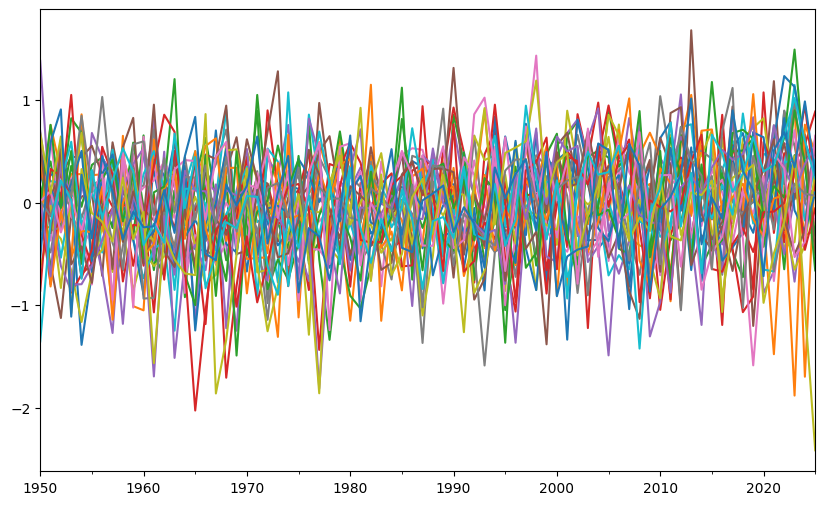

In [121]:
SPI3_hist_yearly_all.plot(figsize=(10, 6), legend=False)

<Axes: >

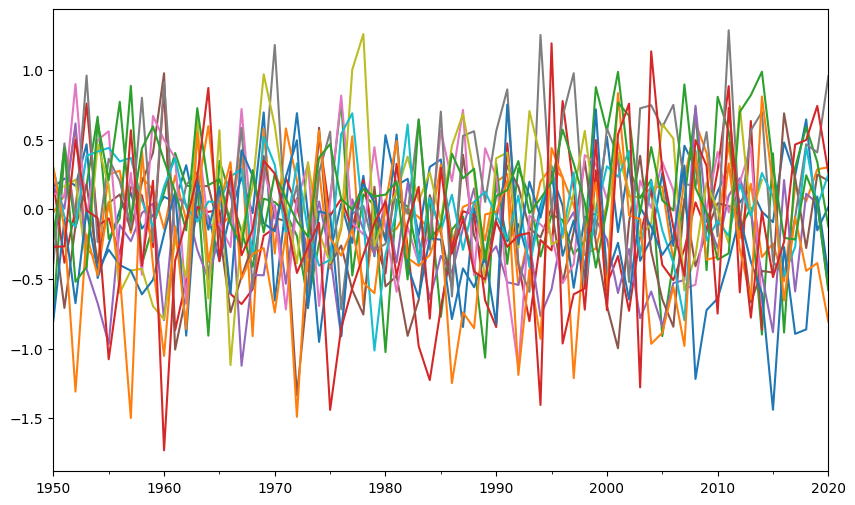

In [124]:
SPI3_nat_yearly_all.plot(figsize=(10, 6), legend=False)

In [130]:
SPI3_hist_yearly_all.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_SPI3_all_yearly_1950_2025.csv')
SPI3_nat_yearly_all.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_SPI3_all_yearly_1950_2020.csv')

In [131]:
# read tas data for historical and NAT senarios, change the time of data under NAT senario and concatenate with historical data
for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    if sn in NAT_source:
        tas_hist = xr.open_dataarray(glob('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/' + 'tas' + '_TP_' + sn + '_' + hist_variant[sn] + '_*.nc')[0])
        tas_nat = xr.open_dataarray(glob('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/NAT/' + 'tas' + '_TP_' + sn + '_' + NAT_variant[sn] + '_*.nc')[0])
        hist_year = tas_hist['time.year']
        nat_year = tas_nat['time.year']
        nat_year_new = nat_year - nat_year[0] + 2026
        tas_nat['time'] = pd.date_range(start=str(nat_year_new.values[0])+'-01', periods=len(nat_year_new), freq='M')
        tas_hist['time'] = pd.date_range(start=str(hist_year.values[0])+'-01', periods=len(hist_year), freq='M')
        tas_nat['time'] = pd.date_range(start=str(nat_year_new.values[0])+'-01', periods=len(nat_year_new), freq='M')
        tas_hist['time'] = pd.date_range(start=str(hist_year.values[0])+'-01', periods=len(hist_year), freq='M')
        tas_hist_nat = xr.concat([tas_hist, tas_nat], dim='time')
        tas_hist_nat = xr.concat([tas_hist, tas_nat], dim='time')

        ds_sti = apply_si_gamma_monthly(tas_hist_nat, 3, data_start_year=hist_year.values[0], calibration_year_initial=1979, calibration_year_final=2022)
        ds_sti.rio.set_crs("epsg:4326")
        ds_sti.rio.set_spatial_dims("lon", "lat", inplace=True)
        ds_sti = ds_sti.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
        ds_sti.name = 'STI3'
        ds_sti.attrs['units'] = 'unitless'
        # separate the historical and natural run
        ds_sti_hist = ds_sti.sel(time=ds_sti['time.year']<=2025)
        ds_sti_nat = ds_sti.sel(time=ds_sti['time.year']>2025)
        ds_sti_nat['time'] = pd.date_range(start=str(nat_year.values[0])+'-01', periods=len(nat_year), freq='M')
        ds_sti_hist.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_monthly_1950_2025.nc')
        ds_sti_nat.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_' + sn + '_monthly_1950_2020.nc')

        ds_sti_hist_yearly = ds_sti_hist.sel(time=ds_sti_hist['time.month']==3)
        ds_sti_nat_yearly = ds_sti_nat.sel(time=ds_sti_nat['time.month']==3)
        ds_sti_hist_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_yearly_1950_2025.nc')
        ds_sti_nat_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_' + sn + '_yearly_1950_2020.nc')

        # calculate area-weighted mean of STI3
        weights = np.cos(np.deg2rad(ds_sti_hist.lat))
        weights.name = 'weights'
        ds_sti_hist_weighted = ds_sti_hist.weighted(weights)
        ds_sti_hist_ts = ds_sti_hist_weighted.mean(('lon','lat'))
        ds_sti_hist_yearly_weighted = ds_sti_hist_yearly.weighted(weights)
        ds_sti_hist_year_ts = ds_sti_hist_yearly_weighted.mean(('lon','lat'))
        ds_sti_hist_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_monthly_1950_2025.csv')
        ds_sti_hist_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_yearly_1950_2025.csv')

        weights = np.cos(np.deg2rad(ds_sti_nat.lat))
        weights.name = 'weights'
        ds_sti_nat_weighted = ds_sti_nat.weighted(weights)
        ds_sti_nat_ts = ds_sti_nat_weighted.mean(('lon','lat'))
        ds_sti_nat_yearly_weighted = ds_sti_nat_yearly.weighted(weights)
        ds_sti_nat_year_ts = ds_sti_nat_yearly_weighted.mean(('lon','lat'))
        ds_sti_nat_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_' + sn + '_monthly_1950_2020.csv')
        ds_sti_nat_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_' + sn + '_yearly_1950_2020.csv')

    else: # for the rest of the models, only calculate the historical run
        tas_hist = xr.open_dataarray('/Volumes/Seagate_ZQ2/SWE_datasets/rawData/CMIP6/HIST/' + 'tas' + '_TP_' + sn + '_' + hist_variant[sn] + '_1950-2025.nc')
        hist_year = tas_hist['time.year']
        ds_sti  = apply_si_gamma_monthly(tas_hist, 3, data_start_year=hist_year.values[0], calibration_year_initial=1979, calibration_year_final=2022)
        ds_sti.rio.set_crs("epsg:4326")
        ds_sti.rio.set_spatial_dims("lon", "lat", inplace=True)
        ds_sti = ds_sti.rio.clip(TP_shp.geometry.apply(mapping), TP_shp.crs)
        ds_sti.name = 'STI3'
        ds_sti.attrs['units'] = 'unitless'
        ds_sti.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_monthly_1950_2025.nc')
        
        ds_sti_yearly = ds_sti.sel(time=ds_sti['time.month']==3)
        ds_sti_yearly.to_netcdf('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_yearly_1950_2025.nc')

        # calculate area-weighted mean of STI3
        weights = np.cos(np.deg2rad(ds_sti.lat))
        weights.name = 'weights'
        ds_sti_weighted = ds_sti.weighted(weights)
        ds_sti_ts = ds_sti_weighted.mean(('lon','lat'))
        ds_sti_yearly_weighted = ds_sti_yearly.weighted(weights)
        ds_sti_year_ts = ds_sti_yearly_weighted.mean(('lon','lat'))
        ds_sti_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_monthly_1950_2025.csv')
        ds_sti_year_ts.to_dataframe().to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_yearly_1950_2025.csv')
        

In [133]:
STI3_hist_yearly_all = pd.DataFrame()
for sn in hist_source:
    if sn == 'GFDL-CM4':
        continue
    ds_sti_yearly = pd.read_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_' + sn + '_yearly_1950_2025.csv', index_col=0, parse_dates=True)['STI3']
    start_year = ds_sti_yearly.index[0].year
    ds_sti_yearly.index = pd.date_range(start=str(start_year)+'-01-01', end='2025', freq='AS') + pd.offsets.MonthBegin(2)
    STI3_hist_yearly_all[sn] = ds_sti_yearly

STI3_nat_yearly_all = pd.DataFrame()
for sn in NAT_source:
    if sn == 'GFDL-CM4':
        continue
    ds_sti_yearly = pd.read_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_' + sn + '_yearly_1950_2020.csv', index_col=0, parse_dates=True)['STI3']
    start_year = ds_sti_yearly.index[0].year
    end_year = ds_sti_yearly.index[-1].year
    ds_sti_yearly.index = pd.date_range(start=str(start_year)+'-01-01', end=str(end_year), freq='AS') + pd.offsets.MonthBegin(2)
    STI3_nat_yearly_all[sn] = ds_sti_yearly


In [136]:
STI3_hist_yearly_all.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_hist/CMIP6_hist_STI3_all_yearly_1950_2025.csv')
STI3_nat_yearly_all.to_csv('/Users/zeqinhuang/Documents/paper/TB_SWE/processed_data/CMIP6_NAT/CMIP6_nat_STI3_all_yearly_1950_2020.csv')